## Denoise Validation


In [1]:
#! lamin init --storage ./lamin-intro --schema bionty 

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scprint.tasks import Denoiser, withknn
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData
%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint2


In [2]:
model_checkpoint_file = hf_hub_download(
    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
)
#model_checkpoint_file = ../data/
model_checkpoint_file

'/home/ml4ig1/.cache/huggingface/hub/models--jkobject--scPRINT/snapshots/d79fad0ff77e19d9ba0c2fad9dfc993b37e92d6d/v2-medium.ckpt'

In [3]:
m = torch.load(model_checkpoint_file)
if "prenorm" in m['hyper_parameters']:
    m['hyper_parameters'].pop("prenorm")
    torch.save(m, model_checkpoint_file)
if "label_counts" in m['hyper_parameters']:
    model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None, classes=m['hyper_parameters']['label_counts'])
else:
    model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.


In [16]:
adata = sc.read('../data/temp/gNNpgpo6gATjuxTE7CCp.h5ad', backup_url="https://datasets.cellxgene.cziscience.com/53bd4177-79c6-40c8-b84d-ff300dcf1b5b.h5ad")
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
#gNNpgpo6gATjuxTE7CCp
#REIyQZE6OMZm1S3W2Dxi
#R4ZHoQegxXdSFNFY5LGe
# "kidney": "https://datasets.cellxgene.cziscience.com/01bc7039-961f-4c24-b407-d535a2a7ba2c.h5ad",
# "glio_smart_highdepth": "https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
# "lung_smart": "https://datasets.cellxgene.cziscience.com/6ebba0e0-a159-406f-8095-451115673a2c.h5ad",

adata.layers['true'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 51370 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'desc

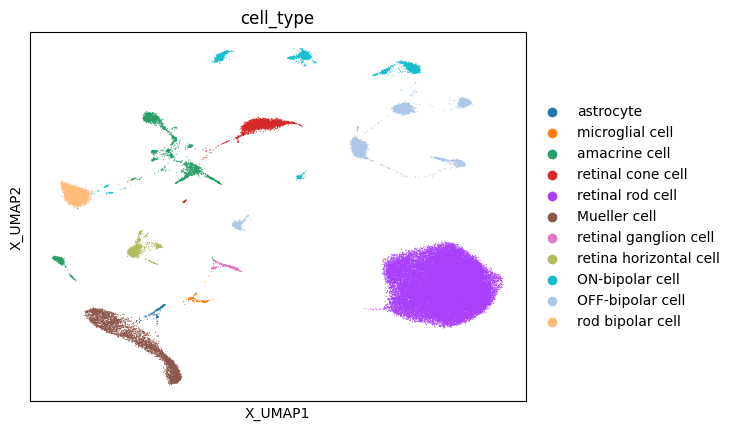

cell_type
retinal rod cell          31858
OFF-bipolar cell           3892
Mueller cell               3668
amacrine cell              2722
ON-bipolar cell            2611
rod bipolar cell           2319
retinal cone cell          2211
retina horizontal cell     1133
retinal ganglion cell       493
astrocyte                   232
microglial cell             231
Name: count, dtype: int64

In [14]:
sc.pl.embedding(adata, basis="X_UMAP", color='cell_type')
adata.obs.cell_type.value_counts()

In [17]:
adata.obs.drop(columns="is_primary_data", inplace=True)
preprocessor = Preprocessor(do_postp=False)
adata = preprocessor(adata)
adata.layers['true'] = adata.X.copy()


Dropping layers:  KeysView(Layers with keys: true)
checking raw counts
removed 0 non primary cells, 51370 renamining
filtered out 0 cells, 51370 renamining
Removed 0 genes.
validating


/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:304: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata, organism=adata.obs.organism_ontology_term_id[0], need_all=False


startin QC
Seeing 22952 outliers (44.68% of total dataset):
done
AnnData object with n_obs × n_vars = 51370 × 70704
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_bio

In [ ]:
scprint vs magic (full vs rare)
33.6 vs 37.7 - 28.2 vs 26.4
30 vs 20 - 28.5 vs 17.5
22.3 vs 23.5 - 23.4 vs 5.0

In [18]:
denoise = Denoiser(
    batch_size=20,
    max_len=5000,
    max_cells=30_000,
    doplot=False,
    predict_depth_mult=5,
    downsample = 0.7,
    how="most var"
)
metrics, idx, adata = denoise(model, adata)
metrics

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 1500/1500 [02:32<00:00,  9.86it/s]


AnnData object with n_obs × n_vars = 30000 × 44756
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


{'reco2noisy': 0.3711852464730351,
 'reco2full': 0.6627596720342318,
 'noisy2full': 0.367251340808255}

## with MAGIC

In [131]:
subadata = adata[idx, adata.var.index.isin(genes) & adata.var.highly_variable].copy() if idx is not None else adata[:, adata.var.index.isin(genes) & adata.var.highly_variable].copy()
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)
subadata.shape


(30000, 3218)

In [132]:
denoised_adata = sc.external.pp.magic(subadata.copy(), copy=True, n_jobs=10, solver='approximate', verbose=True)

Calculating MAGIC...
  Running MAGIC on 30000 cells and 3218 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


    Calculated PCA in 7.78 seconds.
    Calculating KNN search...
    Calculating KNN search...
    Calculated KNN search in 43.37 seconds.
    Calculating affinities...
    Calculated affinities in 42.39 seconds.
  Calculated graph and diffusion operator in 93.61 seconds.
  Calculating imputation...
  Calculated imputation in 0.56 seconds.
Calculated MAGIC in 95.79 seconds.


In [133]:
reco = denoised_adata.X
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.2333469917469311,
 'reco2full': 0.598268919524704,
 'noisy2full': 0.3636214793449458}

## with MAGIC rare cells

In [134]:
ct = "pericyte"
subadata.obs.cell_type.value_counts()
#microglial cell, microfold cell of epithelium of small intestine, mesangial cell, pericyte

cell_type
pigmented ciliary epithelial cell        13383
non-pigmented ciliary epithelial cell     4687
ciliary muscle cell                       3776
fibroblast                                3271
Schwann cell                              1778
macrophage                                1473
melanocyte                                1169
lymphocyte                                 222
blood vessel endothelial cell              149
pericyte                                    92
Name: count, dtype: int64

In [135]:
reco = denoised_adata[subadata.obs.cell_type==ct].X
true = subadata[subadata.obs.cell_type==ct].layers['true'].toarray()
noisy = subadata[subadata.obs.cell_type==ct].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.14750170131134832,
 'reco2full': 0.38880325415511774,
 'noisy2full': 0.3443993707013129}

## MAGIC Rare cell without support

In [170]:
subadata = adata[adata.obs.cell_type==ct, adata.var.index.isin(genes)]
sc.pp.highly_variable_genes(
    subadata, flavor="seurat_v3", n_top_genes=5000, span=0.99)

In [171]:
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)

In [172]:
denoised_adata = sc.external.pp.magic(subadata[:,subadata.var.highly_variable][:30], knn=5, n_jobs=20, solver='approximate', copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 100 dimensions on data with min(n_samples, n_features) = 30
  warnings.warn(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_ta

In [173]:
reco = denoised_adata.X
true = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable].layers['true'][:30].toarray()
noisy = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable][:30].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.3116307487080801,
 'reco2full': 0.4477594810317442,
 'noisy2full': 0.3117786337560895}

## scPRINT rare cells

In [136]:
denoise = Denoiser(
    batch_size=40,
    max_len=5000,
    max_cells=200,
    doplot=False,
    predict_depth_mult=6,
    downsample = 0.7,
    how="most var"
)
metrics, idx, genes, expr = denoise(model, adata[adata.obs.cell_type==ct])
metrics

/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


{'reco2noisy': 0.3439042832146162,
 'reco2full': 0.5496913631860156,
 'noisy2full': 0.31487289773608945}